<a href="https://colab.research.google.com/github/gundasai/deeplearning/blob/master/TBTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connect to the drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/Balanced_PCB')
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


'/content/drive/My Drive/Balanced_PCB'

In [0]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 491kB 52.7MB/s 
     |████████████████████████████████| 3.2MB 55.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


load training data from drive 

(298, 300, 300, 3)
(298,)


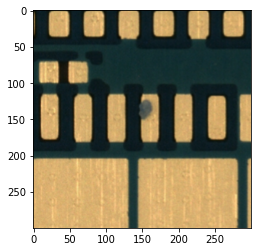

In [0]:
import numpy as np
xtrain=np.load("xtrain.npy")
ytrain=np.load("ytrain.npy")
print(xtrain.shape)
print(ytrain.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(xtrain[0], cmap='brg')

Normalize data 


In [0]:
xtrain = xtrain.astype('float32')
mean = np.mean(xtrain)
std  = np.std(xtrain)

print(mean)
print(std)

xtrain -= mean
xtrain /= std
from keras.utils import to_categorical
ytrain = to_categorical(ytrain)

52.748867
52.869015


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Lenet model

In [0]:
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input
from keras import backend as K

# create the base pre-trained model
input_tensor = Input(shape=(300, 300, 3))
base_model = ResNet50V2(input_tensor=input_tensor,weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

model.summary()


94674944/94668760 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
__________________________

In [0]:
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy' ,metrics=['accuracy'])
history=model.fit(xtrain, ytrain, batch_size=10,epochs=20, verbose=1)


Epoch 1/20
298/298 [==============================] - 195s 653ms/step - loss: 0.5767 - accuracy: 0.7148
Epoch 2/20
298/298 [==============================] - 194s 651ms/step - loss: 0.3381 - accuracy: 0.8658
Epoch 3/20
298/298 [==============================] - 191s 641ms/step - loss: 0.1952 - accuracy: 0.9463
Epoch 4/20
298/298 [==============================] - 190s 638ms/step - loss: 0.0987 - accuracy: 0.9799
Epoch 5/20
298/298 [==============================] - 193s 646ms/step - loss: 0.0600 - accuracy: 0.9866
Epoch 6/20
298/298 [==============================] - 189s 633ms/step - loss: 0.0745 - accuracy: 0.9765
Epoch 7/20
298/298 [==============================] - 189s 634ms/step - loss: 0.0306 - accuracy: 0.9966
Epoch 8/20
298/298 [==============================] - 190s 638ms/step - loss: 0.0153 - accuracy: 1.0000
Epoch 9/20
298/298 [==============================] - 189s 634ms/step - loss: 0.0296 - accuracy: 0.9899
Epoch 10/20
298/298 [==============================] - 188s 630

Test on both raw data 


In [0]:
os.chdir('/content/drive/My Drive/Raw_PCB')
os.getcwd()

'/content/drive/My Drive/Raw_PCB'

(2669, 300, 300, 3)
(2669,)


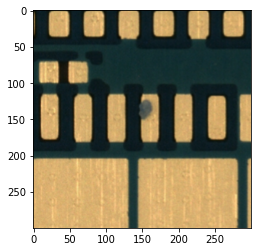

In [0]:
import numpy as np
xtest=np.load("s_x_train.npy")
ytest=np.load("s_y_train.npy")
print(xtest.shape)
print(ytest.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(xtest[0], cmap='brg')

In [0]:
xtest = xtest.astype('float32')
mean = np.mean(xtest)
std  = np.std(xtest)

print(mean)
print(std)

xtest -= mean
xtest /= std
from keras.utils import to_categorical
ytest = to_categorical(ytest)

51.086014
53.93136


In [0]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(xtest)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1']
print(classification_report(np.argmax(ytest,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.24      1.00      0.39       149
     class 1       1.00      0.81      0.90      2520

    accuracy                           0.82      2669
   macro avg       0.62      0.91      0.64      2669
weighted avg       0.96      0.82      0.87      2669



test on Augemented data



In [0]:
os.chdir('/content/drive/My Drive/Aug_PCB')
os.getcwd()

'/content/drive/My Drive/Aug_PCB'

(5040, 300, 300, 3)
(5040,)


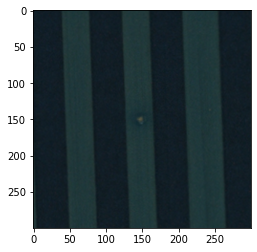

In [0]:
import numpy as np
xtest=np.load("s_x_train.npy")
ytest=np.load("s_y_train.npy")
print(xtest.shape)
print(ytest.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(xtest[0], cmap='brg')

In [0]:
xtest = xtest.astype('float32')
mean = np.mean(xtest)
std  = np.std(xtest)

print(mean)
print(std)

xtest -= mean
xtest /= std
from keras.utils import to_categorical
ytest = to_categorical(ytest)

0.20878915
0.20782994


In [0]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(xtest)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1']
print(classification_report(np.argmax(ytest,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.84      0.98      0.91      2520
     class 1       0.98      0.81      0.89      2520

    accuracy                           0.90      5040
   macro avg       0.91      0.90      0.90      5040
weighted avg       0.91      0.90      0.90      5040

